# Data pre-processing, Knockoffs generation and Visualization
#### Last updated on: Apr 28, 2021
The purpose of this notebook is to allow the generation of knockoffs starting from the raw datasets used in the paper. 

Also included are functions to help with visualizing the contributions of the discrete wavelet transform features to the signal. 

## Load required modules

In [80]:
%load_ext autoreload
%autoreload 2
import os, sys
dataset_folder = './datasets/'
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pywt
import copy
import pandas as pd
import numpy as np
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load raw data 
* <b>wv</b>: Shape (n,) array of wavenumbers
* <b>X_raw</b>: Shape (n, p) array of spectral intensities
* <b>Y</b>: Shape (n,3) dataframe, 3 columns corresponding to labels for the following tasks:

<b><i>Task 1: Y_species (30 classes)</i></b> <br>
0: MRSA 1 (isogenic)
1: MRSA 2
2: MSSA 1
3: MSSA 2
4: MSSA 3
5: S. epidermidis
6: S. lugdunensis
7: S.pneumoniae 1
8: S.pneumoniae 2
9: Group A Strep.
10: Group B Strep.
11: Group C Strep.
12: Group G Strep.
13: S. sanguinis
14: E. faecalis 1
15: E. faecalis 2
16: E. facium
17: E. coli 1
18: E. coli 2
19: K. pneumoniae 1
20: K. pneumoniae 2
21: K. aerogenes
22: E. cloacae
23: P. mirabilis
24: S. marcescens
25: S. enterica
26: P. aeruginosa 1
27 P. aeruginosa 2
28: C. albicans
29: C. glabrata

<b><i>Task 2: Y_empiric_treatments </i></b><br>
0: Vancomycin
1: Ceftriaxone
2: Penicillin
3: Daptomycin
4: Meropenem
5: Ciprofloxacin
6: TZP
7: Caspofungin

<b><i>Task 3: Y_MRSA_MSSA </i></b><br>
0: MRSA
1: MSSA

In [4]:
# load wavenumbers array
wv = np.load(f"{dataset_folder}wv.npy")

# load spectra intensities array
X_raw = np.load(f"{dataset_folder}X_raw.npy") 

# load labels
Y_all = pd.read_csv(f"{dataset_folder}Y.csv", usecols=[0,1,2])

# define p, n
n, p = X_raw.shape
print(f"n={n}, p={p}")

n=60000, p=992


#### Select X and Y data specific to one of the 3 classification tasks

In [7]:
# get dataset specific to task 
colname = 'Y_species' # 'Y_empiric_treatments'# 'Y_MRSA_MSSA' ### MODIFY THIS TO SELECT THE REQUIRED DATASET
Y_task = np.array(list(Y_all[colname]))
samples_to_include = ~np.isnan(Y_task)

# select only rows with non-NaN labels for specific task to be included in final X_raw and Y datasets
Y_task = Y_task[samples_to_include]
X_raw_task = X_raw[samples_to_include]

## Perform Discrete Wavelet Transform (DWT) to get transformed signal dataset (X_dwt)

#### Set wavelet parameters to be used in DWT & visualize wavelet basis functions
* Wavelet type: 'coiflets' was selected, but this can be modified to any other wavelet basis
* DWT level: This was chosen to be the maximum level useful level of decomposition for the signal.  This is determined using the dwt_max level function in the pywavelets module. The rational for the choice of levels is the maximum level where at least one coefficient in the output is uncorrupted by edge effects caused by signal extension. Put another way, decomposition stops when the signal becomes shorter than the FIR filter length for a given wavelet.

Wavelet coif4
  Family name:    Coiflets
  Short name:     coif
  Filters length: 24
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False 
 Maximum DWT level: 5


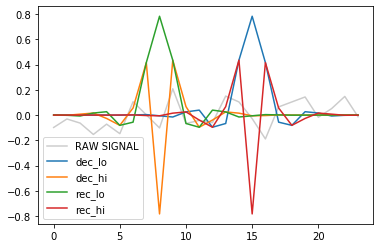

# of coefficients in each DWT level: [53, 53, 83, 144, 265, 507]
Idx+1 of last feature in each level in flattened array of coefficients: [53, 106, 189, 333, 598, 1105]


In [66]:
w = 'coif4' # Select wavelet to use
wavelet = pywt.Wavelet(w) 
dwt_max_level = pywt.dwt_max_level(data_len=p, filter_len=wavelet.dec_len)
print(wavelet, "\n", f"Maximum DWT level: {dwt_max_level}")

# visualize wavelet basis
filterlen = len(wavelet.dec_lo)
plt.plot(X_raw[0,:filterlen]-np.mean(X_raw[0,:filterlen]), 'k', alpha=0.2)
plt.plot(wavelet.dec_lo)
plt.plot(wavelet.dec_hi)
plt.plot(wavelet.rec_lo)
plt.plot(wavelet.rec_hi)
plt.legend(['RAW SIGNAL','dec_lo','dec_hi','rec_lo','rec_hi'])
plt.show()

# get coefficient array lengths for each level of wavelet coefficients -- this will help us with visualizing features later
coef_count, coef_idx_bylevel = get_coef_count_in_each_dwt_level(p, w, dwt_max_level, mode='symmetric')

#### Perform DWT on array of spectra (X_raw), followed by inversed DWT to reconstruct signal

In [88]:
# perform DWT on signal array 
X_dwt = perform_dwt_on_signal_array(X_raw, wavelet_type='coif4', mode='symmetric')

# perform IDWT on coefficient array to get reconstructed signal
X_raw_reconstructed = perform_idwt_on_coef_array(X_dwt, p=992, wavelet_type='coif4', mode='symmetric', level=None)

# of coefficients in each DWT level: [53, 53, 83, 144, 265, 507]
Idx+1 of last feature in each level in flattened array of coefficients: [53, 106, 189, 333, 598, 1105]


#### Visualize different levels of reconstructed signal
We can visualize the additive and individual contributions of each level of DWT features to the reconstructed signal, starting with the level 5 approximation coefficient, down to the level 1 detail coefficients. 

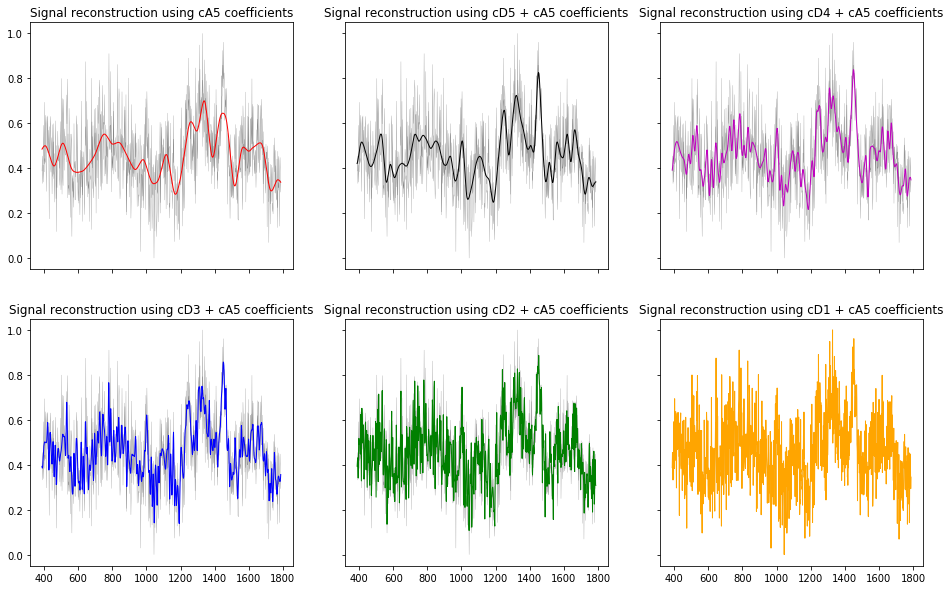

In [70]:
i = 0
signal = X_raw[i,:]
coef_flattened = X_dwt[i,:]
coef_bank = coef_flattened_to_bank(coef_flattened, p, wavelet_type='coif4', mode='symmetric', level=None)
visualize_reconstructed_signal_bylevel(coef_bank, signal, wv, wavelet_type='coif4', mode='symmetric', plot_approximation_bkgd=True)

#### Plot individual wavelet feature contributions to the reconstructed signal
We can also visualize the contribution of indivdual DWT wavelet features (from various levels). This is done by setting all other feature coefficients to zero and reconstructing the signal from the selected features only.

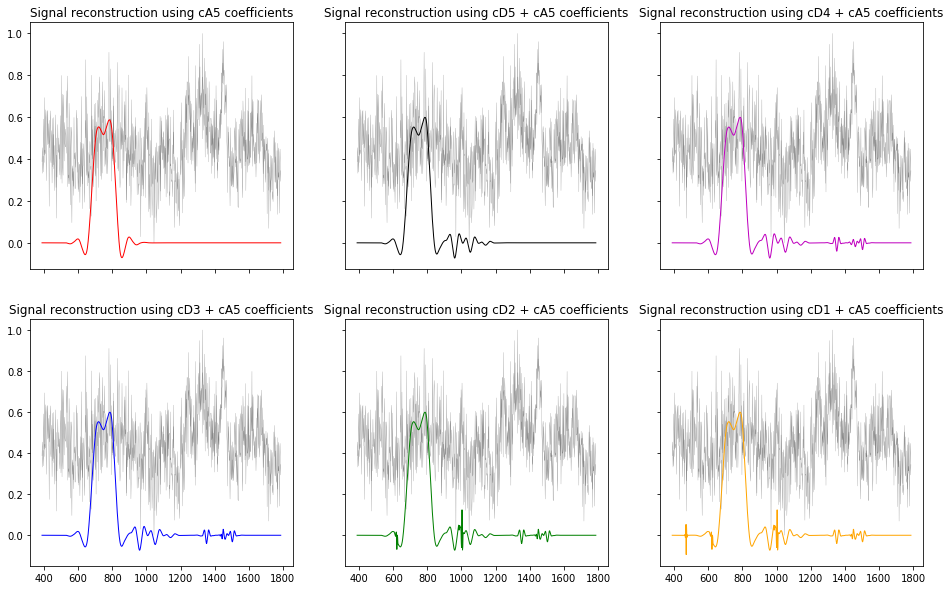

In [74]:
selected_feature_idxs = [20, 21, 22, 
                     72, 73, 75, 77, 79, 
                     157, 161, 162, 164, 
                     289, 295, 
                     378, 440, 443, 
                     628]
coef_bank_filt = get_filtered_coef_bank(coef_bank, selected_feature_idxs)

# plot levels separately (overlaying background shape from approximation coefficients), against unfiltered signal
visualize_reconstructed_signal_bylevel(coef_bank_filt, signal, wv, wavelet_type='coif4', mode='symmetric', plot_approximation_bkgd=True)

## Generate Knockoffs from 1) Raw spectral dataset (X_raw) and 2) DWT-featurized dataset (X_dwt)
This is done by calling the class GaussianKnockoffs, adapted from the codebase (https://github.com/msesia/deepknockoffs) provided by Matteo Sesia and Yaniv Romano along with the following paper: <br> 
<i>Romano, Sesia, and Candès. (2019). "Deep Knockoffs." J. Am. Stat. Assoc.. 0(0), pages 1-12. </i>

#### Generate Knockoffs from X_raw
Note: a small 'epsilon' eye is added to the diagonal of the covariance matrix used to generate the knockoffs, so as to ensure that the matrix is positive degenerate.

In [81]:
%load_ext autoreload
%autoreload 2
from gaussian import GaussianKnockoffs
epsilon = 3e-4 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
SigmaHat_raw = np.cov(X_raw, rowvar=False)
SigmaHat_raw = SigmaHat_raw*(1-epsilon) + epsilon*np.eye(SigmaHat_raw.shape[0])

# Initialize knockoffs generator
second_order_raw = GaussianKnockoffs(SigmaHat_raw, mu=np.mean(X_raw,0), method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat_raw) - np.diag(second_order.Ds)) / np.diag(SigmaHat_raw)
print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

# Generate knockoffs
Xk_raw = second_order_raw.generate(X_raw)

Average absolute pairwise correlation: 0.327.


#### Generate knockoffs from X_dwt

In [ ]:
SigmaHat_dwt = np.cov(X_dwt, rowvar=False)
SigmaHat_dwt = SigmaHat_dwt*(1-epsilon) + epsilon*np.eye(SigmaHat_dwt.shape[0])

# Initialize knockoffs generator
second_order_dwt = GaussianKnockoffs(SigmaHat_dwt, mu=np.mean(X_dwt,0), method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat_dwt) - np.diag(second_order_dwt.Ds)) / np.diag(SigmaHat_dwt)
print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

# Generate knockoffs
Xk_dwt = second_order_dwt.generate(X_dwt)

#### Visualize example of knockoff signal generated from X

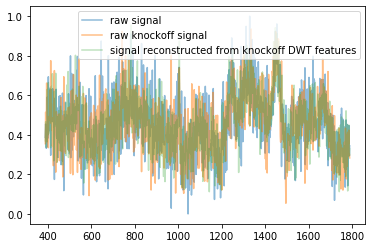

In [92]:
i = 0
plt.plot(wv, X_raw[i,:], alpha=0.5)
plt.plot(wv, Xk_raw[i,:], alpha=0.5)
plt.plot(wv, pywt.waverec(coef_flattened_to_bank(Xk_dwt[i,:], wavelet_type='coif4', mode='symmetric', level=None), 'coif4', mode='symmetric', axis=-1), alpha=0.3)
plt.legend(['raw signal', 'raw knockoff signal', 'signal reconstructed from knockoff DWT features'])
plt.show()

#### Plot cross-correlation map of knockoffs and original datasets (e.g. for X_dwt)

0.1775439157212565


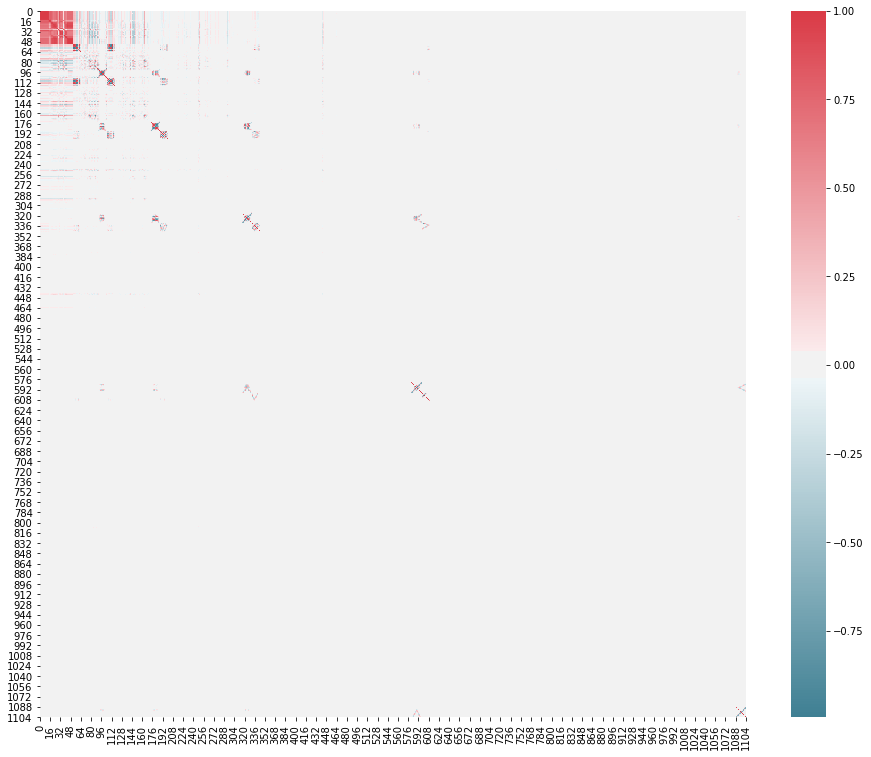

In [94]:
import seaborn as sns

Ghat = np.corrcoef(X_dwt,Xk_dwt,rowvar=False)
p = X_dwt.shape[1]
selfcorr_mat = Ghat[0:p,p:(2*p)]
selfcorr = np.diag(selfcorr_mat)
print(np.mean(selfcorr))

# Generate a custom diverging colormap
f, ax = plt.subplots(figsize=(16, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(selfcorr_mat[:,:], cmap=cmap, square=True) 
plt.show()